# KE5018 Time Series Forecasting

## Load libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

## Load time series data

In [2]:
ts_df = pd.read_excel('data/ActualRatings_weeklyGRP.xls', sheet_name=1)

In [3]:
ts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
GRPRatingsDate    92 non-null object
GRP               92 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.5+ KB


In [4]:
ts_df.head()

,GRPRatingsDate,GRP
0,17-Jun-2007 (25),243.60
1,24-Jun-2007 (26),263.19
2,01-Jul-2007 (27),269.89
3,08-Jul-2007 (28),252.88
4,15-Jul-2007 (29),303.46


In [5]:
ts_df.tail()

,GRPRatingsDate,GRP
87,15-Feb-2009 (8),204.20
88,22-Feb-2009 (9),200.61
89,01-Mar-2009 (10),208.56
90,08-Mar-2009 (11),191.74
91,15-Mar-2009 (12),222.07


## Transform the Data for Analysis

In [6]:
# Create a date/time column for week.
ts_df['weekly_date'] = pd.date_range('17/6/2007', '15/3/2009', freq='W')

In [7]:
ts_df.head()

,GRPRatingsDate,GRP,weekly_date
0,17-Jun-2007 (25),243.60,2007-06-17
1,24-Jun-2007 (26),263.19,2007-06-24
2,01-Jul-2007 (27),269.89,2007-07-01
3,08-Jul-2007 (28),252.88,2007-07-08
4,15-Jul-2007 (29),303.46,2007-07-15


In [8]:
# Index the data frame by week. Keep the original index as a running number by week. 
ts_df.reset_index(inplace=True)
ts_df.set_index('weekly_date', inplace=True)

In [9]:
ts_df.head()

,index,GRPRatingsDate,GRP
weekly_date,,,
2007-06-17,0,17-Jun-2007 (25),243.60
2007-06-24,1,24-Jun-2007 (26),263.19
2007-07-01,2,01-Jul-2007 (27),269.89
2007-07-08,3,08-Jul-2007 (28),252.88
2007-07-15,4,15-Jul-2007 (29),303.46


In [10]:
ts_df.rename(columns={'index':'week'}, inplace=True)

In [11]:
ts_df.describe()

,week,GRP
count,92.00000,92.000000
mean,45.50000,240.829783
std,26.70206,38.680913
min,0.00000,170.740000
25%,22.75000,209.980000
50%,45.50000,231.490000
75%,68.25000,272.927500
max,91.00000,327.220000


In [12]:
# Save the data frame to file.
ts_df.to_csv('data/transformedRatings.csv')

## Show the Time Series Data

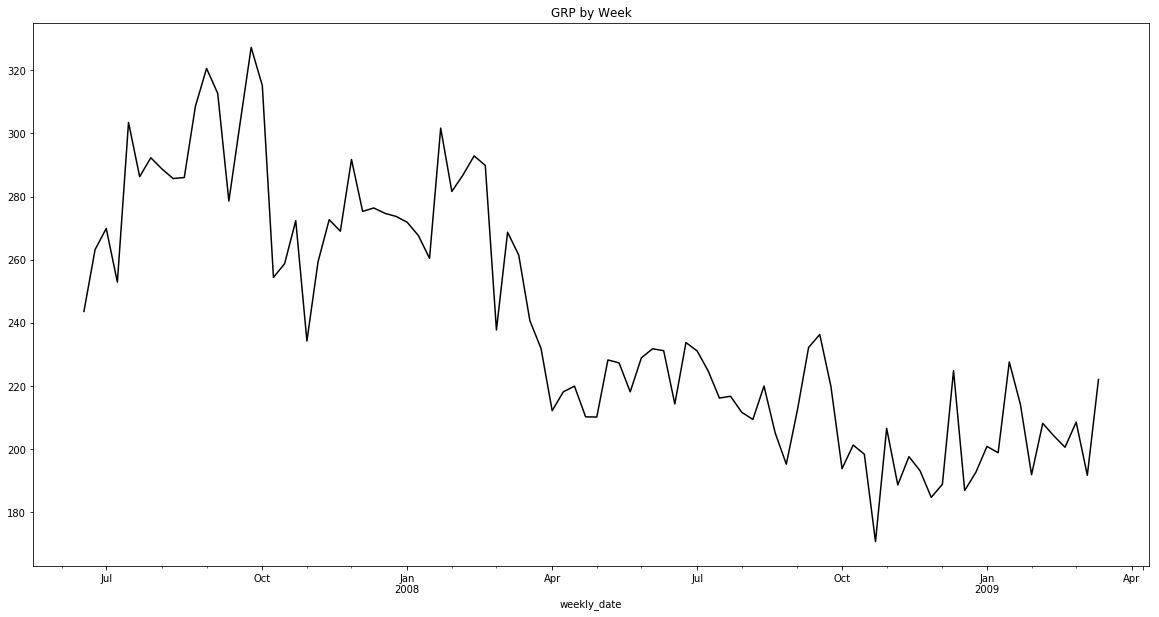

In [13]:
ts_df['GRP'].plot(figsize=(20, 10), title='GRP by Week', color='black')

The plot for the time series data shows a decreasing seasonal variation.

## Prepare the Train / Test Datasets

In [14]:
train_ts_df = ts_df.loc['17/6/2007':'17/6/2008']
test_ts_df = ts_df.loc['18/6/2008':]

In [15]:
train_ts_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53 entries, 2007-06-17 to 2008-06-15
Data columns (total 3 columns):
week              53 non-null int64
GRPRatingsDate    53 non-null object
GRP               53 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ KB


In [16]:
test_ts_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39 entries, 2008-06-22 to 2009-03-15
Data columns (total 3 columns):
week              39 non-null int64
GRPRatingsDate    39 non-null object
GRP               39 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.2+ KB


In [17]:
train_ts_df['GRP'].values

array([ 243.6 ,  263.19,  269.89,  252.88,  303.46,  286.29,  292.28,
        288.72,  285.7 ,  286.01,  308.59,  320.57,  312.67,  278.58,
        303.06,  327.22,  315.14,  254.39,  258.73,  272.35,  234.26,
        259.35,  272.67,  269.03,  291.72,  275.29,  276.38,  274.68,
        273.7 ,  271.84,  267.63,  260.45,  301.67,  281.6 ,  286.82,
        292.87,  289.84,  237.74,  268.69,  261.46,  240.68,  231.89,
        212.18,  218.16,  219.96,  210.24,  210.17,  228.25,  227.32,
        218.16,  228.92,  231.79,  231.19])

In [18]:
# Save train, test datasets to file.
train_ts_df.to_csv('data/transformedTrainRatings.csv')
test_ts_df.to_csv('data/transformedTestRatings.csv')

## Linear Regression Model

In [19]:
lin_reg = LinearRegression()
lin_reg.fit(train_ts_df['week'].values.reshape(-1, 1), train_ts_df['GRP'].values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Training Results

In [20]:
lin_reg_train_pred = lin_reg.predict(train_ts_df['week'].values.reshape(-1, 1))
lin_reg_train_pred[:10]

array([ 299.22079665,  297.92995323,  296.63910982,  295.34826641,
        294.057423  ,  292.76657958,  291.47573617,  290.18489276,
        288.89404935,  287.60320593])

In [21]:
lin_reg_train_mse = mean_squared_error(train_ts_df['GRP'].values, lin_reg_train_pred)
lin_reg_train_mse

552.06928509400495

In [22]:
lin_reg_train_rmse = np.sqrt(lin_reg_train_mse)
lin_reg_train_rmse

23.496154687395233

In [23]:
lin_reg_r2 = r2_score(train_ts_df['GRP'].values, lin_reg_train_pred)
#lin_reg_r2 = lin_reg.score(train_ts_df['week'].values.reshape(-1, 1), train_ts_df['GRP'].values)
lin_reg_r2

0.41392552296433993

### Test Results

In [24]:
lin_reg_test_pred = lin_reg.predict(test_ts_df['week'].values.reshape(-1, 1))
lin_reg_test_pred[:10]

array([ 230.80609579,  229.51525238,  228.22440897,  226.93356555,
        225.64272214,  224.35187873,  223.06103532,  221.7701919 ,
        220.47934849,  219.18850508])

In [25]:
lin_reg_test_mse = mean_squared_error(test_ts_df['GRP'].values, lin_reg_test_pred)
lin_reg_test_rmse = np.sqrt(lin_reg_test_mse)
print('mse = %f\nrmse = %f'% (lin_reg_test_mse, lin_reg_test_rmse))

mse = 277.590290
rmse = 16.661041


In [26]:
results_list = []
results_list.append([lin_reg_train_mse, lin_reg_train_rmse, lin_reg_r2, lin_reg_test_mse, lin_reg_test_rmse])
results_list

[[552.06928509400495,
  23.496154687395233,
  0.41392552296433993,
  277.59028980680466,
  16.661041078120078]]

### Plot the Predicted Results

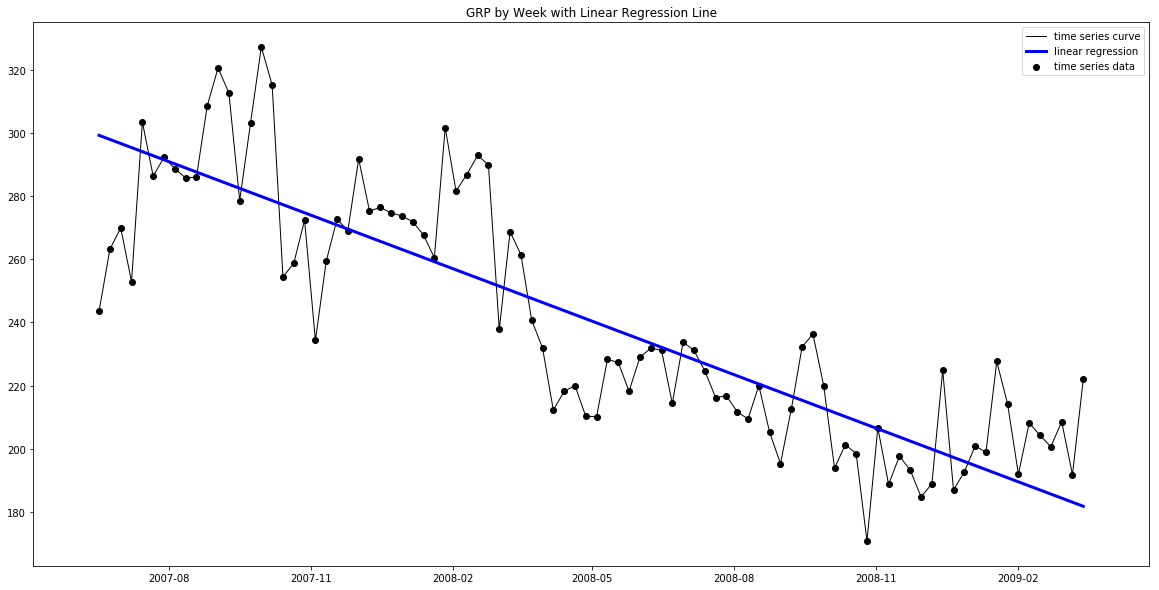

In [27]:
plt.figure(figsize=(20, 10))
plt.title('GRP by Week with Linear Regression Line')
plt.scatter(ts_df.index.values, ts_df['GRP'].values, color='black', label='time series data')
plt.plot(ts_df.index.values, ts_df['GRP'].values, color='black', linewidth=1, label='time series curve')
plt.plot(ts_df.index.values, np.concatenate([lin_reg_train_pred, lin_reg_test_pred]), color='blue', linewidth=3, label='linear regression')
plt.legend()
plt.show()

### Analysis of Residuals

In [28]:
#train_ts_df['residuals'] = train_ts_df['GRP'].values - lin_reg_train_pred
residuals = train_ts_df['GRP'].values - lin_reg_train_pred
residuals

array([-55.62079665, -34.73995323, -26.74910982, -42.46826641,
         9.402577  ,  -6.47657958,   0.80426383,  -1.46489276,
        -3.19404935,  -1.59320593,  22.27763748,  35.54848089,
        28.9393243 ,  -3.85983229,  21.91101113,  47.36185454,
        36.57269795, -22.88645864, -17.25561522,  -2.34477181,
       -39.1439284 , -12.76308499,   1.84775843,  -0.50139816,
        23.47944525,   8.34028866,  10.72113208,  10.31197549,
        10.6228189 ,  10.05366231,   7.13450572,   1.24534914,
        43.75619255,  24.97703596,  31.48787937,  38.82872279,
        37.0895662 , -13.71959039,  18.52125302,  12.58209644,
        -6.90706015, -14.40621674, -32.82537333, -25.55452991,
       -22.4636865 , -30.89284309, -29.67199968, -10.30115627,
        -9.94031285, -17.80946944,  -5.75862603,  -1.59778262,  -0.9069392 ])

In [29]:
poly_reg_res = Pipeline([('poly', PolynomialFeatures(degree=3)),
                         ('linear', LinearRegression(fit_intercept=False))])
poly_reg_res.fit(train_ts_df['week'].values.reshape(-1, 1), residuals)
poly_reg_res_pred = poly_reg_res.predict(train_ts_df['week'].values.reshape(-1, 1))

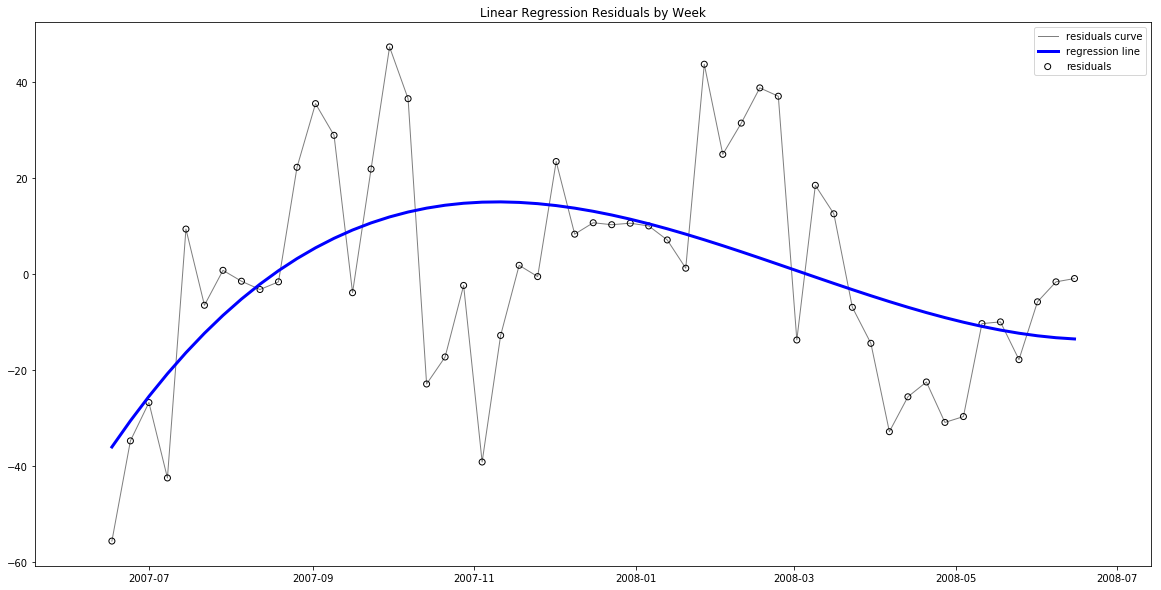

In [30]:
plt.figure(figsize=(20, 10))
plt.title('Linear Regression Residuals by Week')
plt.scatter(train_ts_df.index.values, residuals, color='black', marker='o', label='residuals', facecolors='none')
plt.plot(train_ts_df.index.values, residuals, color='black', linewidth=1, label='residuals curve', alpha=.5)
plt.plot(train_ts_df.index.values, poly_reg_res_pred, color='blue', linewidth=3, label='regression line')
plt.legend()
plt.show()

The residuals are not white noise. The linear model is not a suitable functional form for the time series data.

## Polynomial Regression Model

In [31]:
poly_reg = Pipeline([('poly', PolynomialFeatures(degree=3)),
                         ('linear', LinearRegression(fit_intercept=False))])
poly_reg.fit(train_ts_df['week'].values.reshape(-1, 1), train_ts_df['GRP'])
poly_reg_train_pred = poly_reg.predict(train_ts_df['week'].values.reshape(-1, 1))

### Training Results

In [32]:
poly_reg_train_mse = mean_squared_error(train_ts_df['GRP'].values, poly_reg_train_pred)
poly_reg_train_rmse = np.sqrt(poly_reg_train_mse)
print('mse = %f\nrmse = %f' % (poly_reg_train_mse, poly_reg_train_rmse))

mse = 392.078675
rmse = 19.800977


In [33]:
poly_reg_r2 = r2_score(train_ts_df['GRP'].values, poly_reg_train_pred)
poly_reg_r2

0.58377089546071503

### Test Results

In [34]:
poly_reg_test_pred = poly_reg.predict(test_ts_df['week'].values.reshape(-1, 1))
poly_reg_test_mse = mean_squared_error(test_ts_df['GRP'].values, poly_reg_test_pred)
poly_reg_test_rmse = np.sqrt(poly_reg_test_mse)
print('mse = %f\nrmse = %f' % (poly_reg_test_mse, poly_reg_test_rmse))

mse = 5331.790540
rmse = 73.019111


In [35]:
results_list.append([poly_reg_train_mse, poly_reg_train_rmse, poly_reg_r2, poly_reg_test_mse, poly_reg_test_rmse])
results_list

[[552.06928509400495,
  23.496154687395233,
  0.41392552296433993,
  277.59028980680466,
  16.661041078120078],
 [392.07867460902827,
  19.800976607456217,
  0.58377089546071503,
  5331.7905399494612,
  73.019110785803605]]

In [36]:
results_list

[[552.06928509400495,
  23.496154687395233,
  0.41392552296433993,
  277.59028980680466,
  16.661041078120078],
 [392.07867460902827,
  19.800976607456217,
  0.58377089546071503,
  5331.7905399494612,
  73.019110785803605]]

### Plot the Predicted Results

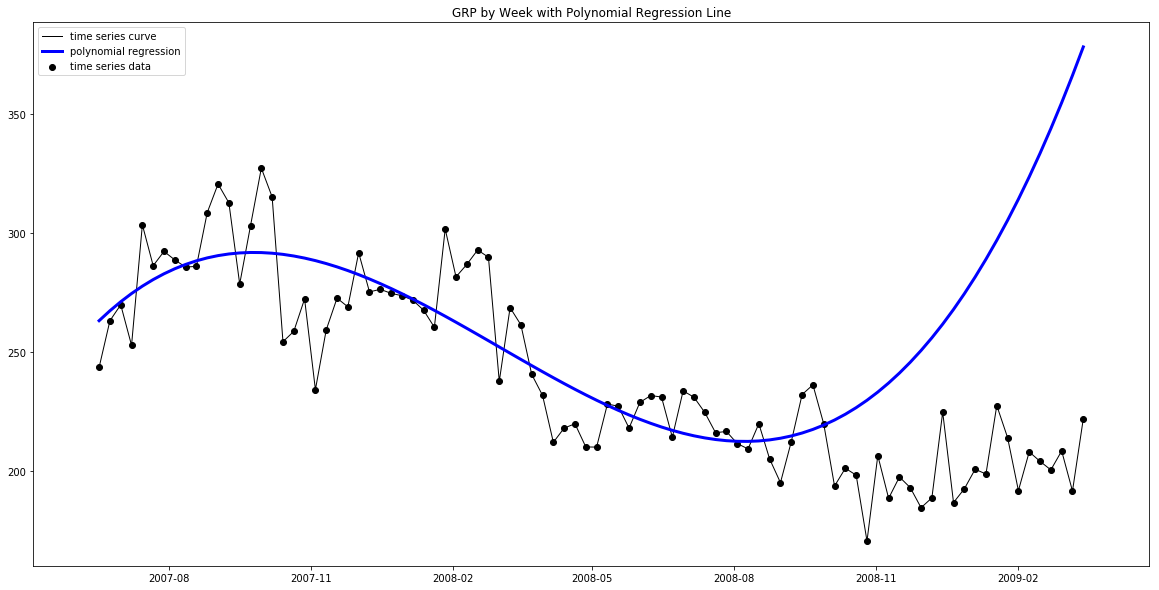

In [37]:
plt.figure(figsize=(20, 10))
plt.title('GRP by Week with Polynomial Regression Line')
plt.scatter(ts_df.index.values, ts_df['GRP'].values, color='black', label='time series data')
plt.plot(ts_df.index.values, ts_df['GRP'].values, color='black', linewidth=1, label='time series curve')
plt.plot(ts_df.index.values, np.concatenate([poly_reg_train_pred, poly_reg_test_pred]), color='blue', linewidth=3, label='polynomial regression')
plt.legend()
plt.show()

The polynomial regression model generalises poorly to the test data. Higher degree polynomial models perform worse.

### Analysis of Residuals

In [38]:
residuals = train_ts_df['GRP'].values - poly_reg_train_pred
poly_reg_res = Pipeline(
    [
        ('poly', PolynomialFeatures(degree=4)),
        ('linear', LinearRegression(fit_intercept=False))])
poly_reg_res.fit(train_ts_df['week'].values.reshape(-1, 1), residuals)
poly_reg_res_pred = poly_reg_res.predict(train_ts_df['week'].values.reshape(-1, 1))

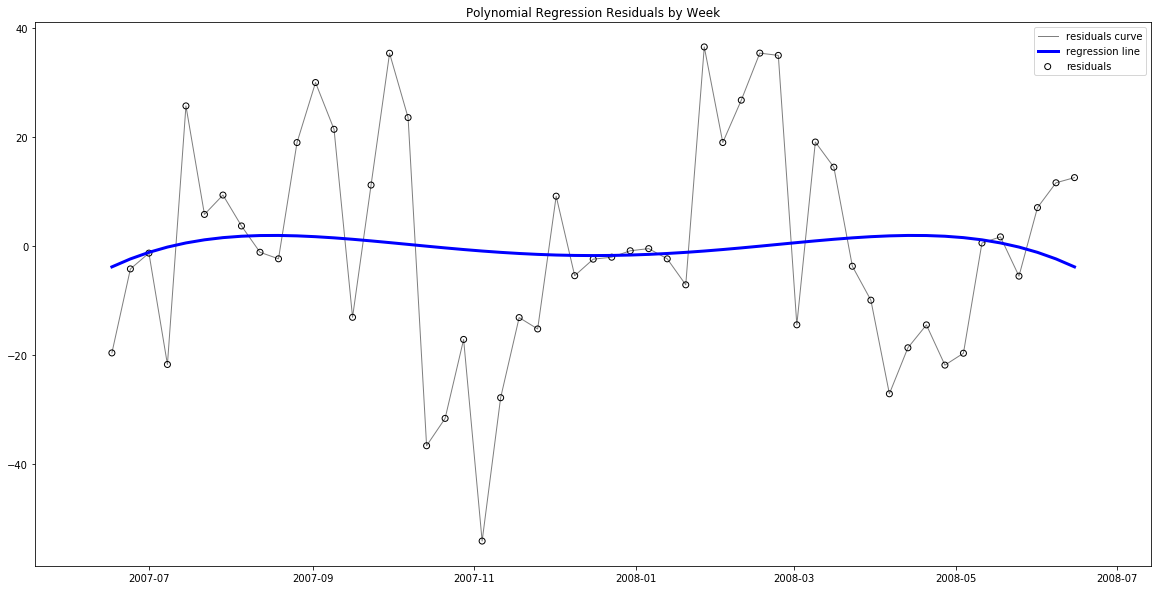

In [39]:
plt.figure(figsize=(20, 10))
plt.title('Polynomial Regression Residuals by Week')
plt.scatter(train_ts_df.index.values, residuals, color='black', marker='o', label='residuals', facecolors='none')
plt.plot(train_ts_df.index.values, residuals, color='black', linewidth=1, label='residuals curve', alpha=.5)
plt.plot(train_ts_df.index.values, poly_reg_res_pred, color='blue', linewidth=3, label='regression line')
plt.legend()
plt.show()

The residuals resembles white noise. The model is properly fitted.

## Dummy Variable Regression

As the plot for the time series data show a decreasing seasonal variation, we can try a Box-Cox transformation to convert the changing variation to a constant variation.

In [40]:
ts_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 92 entries, 2007-06-17 to 2009-03-15
Data columns (total 3 columns):
week              92 non-null int64
GRPRatingsDate    92 non-null object
GRP               92 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 5.4+ KB


In [41]:
ts_df['GRP-trnsf'] = np.log(ts_df['GRP'])
ts_df.head()

,week,GRPRatingsDate,GRP,GRP-trnsf
weekly_date,,,,
2007-06-17,0,17-Jun-2007 (25),243.60,5.495528
2007-06-24,1,24-Jun-2007 (26),263.19,5.572876
2007-07-01,2,01-Jul-2007 (27),269.89,5.598014
2007-07-08,3,08-Jul-2007 (28),252.88,5.532915
2007-07-15,4,15-Jul-2007 (29),303.46,5.715250


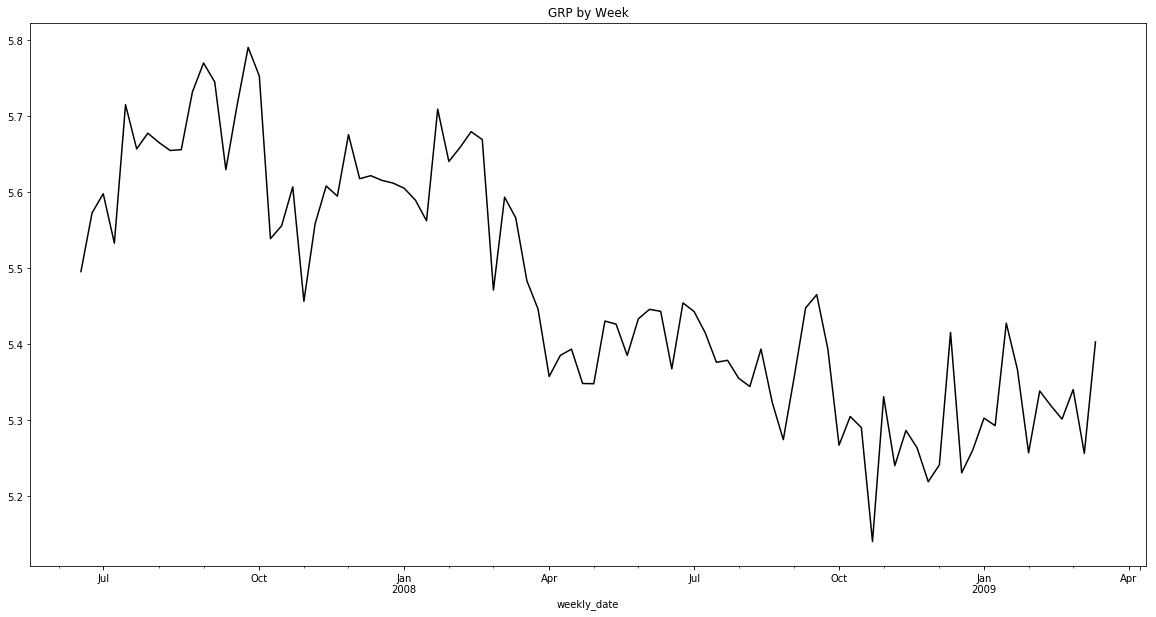

In [42]:
ts_df['GRP-trnsf'].plot(figsize=(20, 10), title='GRP by Week', color='black')

### Create the Dummy Variables for Month

In [43]:
ts_df['month'] = ts_df.index.month

In [44]:
pd.get_dummies(ts_df['month']).head()

,1,2,3,4,5,6,7,8,9,10,11,12
weekly_date,,,,,,,,,,,,
2007-06-17,0,0,0,0,0,1,0,0,0,0,0,0
2007-06-24,0,0,0,0,0,1,0,0,0,0,0,0
2007-07-01,0,0,0,0,0,0,1,0,0,0,0,0
2007-07-08,0,0,0,0,0,0,1,0,0,0,0,0
2007-07-15,0,0,0,0,0,0,1,0,0,0,0,0


In [45]:
ts_dummy_df = pd.concat([pd.get_dummies(ts_df['month']), ts_df.drop(labels='month', axis=1)], axis=1)

In [46]:
ts_dummy_df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,week,GRPRatingsDate,GRP,GRP-trnsf
weekly_date,,,,,,,,,,,,,,,,
2007-06-17,0,0,0,0,0,1,0,0,0,0,0,0,0,17-Jun-2007 (25),243.60,5.495528
2007-06-24,0,0,0,0,0,1,0,0,0,0,0,0,1,24-Jun-2007 (26),263.19,5.572876
2007-07-01,0,0,0,0,0,0,1,0,0,0,0,0,2,01-Jul-2007 (27),269.89,5.598014
2007-07-08,0,0,0,0,0,0,1,0,0,0,0,0,3,08-Jul-2007 (28),252.88,5.532915
2007-07-15,0,0,0,0,0,0,1,0,0,0,0,0,4,15-Jul-2007 (29),303.46,5.715250


In [47]:
# Split into training and test datasets.
train_ts_dummy_df = ts_dummy_df.loc['17/6/2007':'17/6/2008']
test_ts_dummy_df = ts_dummy_df.loc['18/6/2008':]

### Linear Regression Model with Dummy Variables

In [48]:
# Using GRP
dummy_var_reg = LinearRegression()
dummy_var_reg.fit(train_ts_dummy_df.iloc[:, :13].values, train_ts_dummy_df['GRP'])
dummy_var_reg_train_pred = dummy_var_reg.predict(train_ts_dummy_df.iloc[:, :13].values)

# Using ln GRP
dummy_var_reg_trnsf = LinearRegression()
dummy_var_reg_trnsf.fit(train_ts_dummy_df.iloc[:, :13].values, train_ts_dummy_df['GRP-trnsf'])
dummy_var_reg_trnsf_train_pred = np.exp(dummy_var_reg_trnsf.predict(train_ts_dummy_df.iloc[:, :13].values))

### Training Results

In [49]:
# Using GRP
dummy_var_reg_train_mse = mean_squared_error(train_ts_dummy_df['GRP'].values, dummy_var_reg_train_pred)
dummy_var_reg_train_rmse = np.sqrt(dummy_var_reg_train_mse)
print('mse = %f\nrmse = %f' % (dummy_var_reg_train_mse, dummy_var_reg_train_rmse))

mse = 178.852264
rmse = 13.373566


In [50]:
dummy_var_reg_r2 = r2_score(train_ts_dummy_df['GRP'].values, dummy_var_reg_train_pred)
dummy_var_reg_r2

0.81013117337633256

In [51]:
# Using ln GRP
dummy_var_reg_trnsf_train_mse = mean_squared_error(train_ts_dummy_df['GRP'].values, dummy_var_reg_trnsf_train_pred)
dummy_var_reg_trnsf_train_rmse = np.sqrt(dummy_var_reg_trnsf_train_mse)
print('mse = %f\nrmse = %f' % (dummy_var_reg_trnsf_train_mse, dummy_var_reg_trnsf_train_rmse))

mse = 179.350545
rmse = 13.392182


In [52]:
dummy_var_reg_trnsf_r2 = r2_score(train_ts_dummy_df['GRP'].values, dummy_var_reg_trnsf_train_pred)
dummy_var_reg_trnsf_r2

0.8096022007376944

### Test Results

In [53]:
# Using GRP
dummy_var_reg_test_pred = dummy_var_reg.predict(test_ts_dummy_df.iloc[:, :13].values)
dummy_var_reg_test_mse = mean_squared_error(test_ts_dummy_df['GRP'].values, dummy_var_reg_test_pred)
dummy_var_reg_test_rmse = np.sqrt(dummy_var_reg_test_mse)
print('mse = %f\nrmse = %f' % (dummy_var_reg_test_mse, dummy_var_reg_test_rmse))

mse = 2819.982555
rmse = 53.103508


In [54]:
# Using ln GRP
dummy_var_reg_trnsf_test_pred = np.exp(dummy_var_reg_trnsf.predict(test_ts_dummy_df.iloc[:, :13].values))
dummy_var_reg_trnsf_test_mse = mean_squared_error(test_ts_dummy_df['GRP'].values, dummy_var_reg_trnsf_test_pred)
dummy_var_reg_trnsf_test_rmse = np.sqrt(dummy_var_reg_trnsf_test_mse)
print('mse = %f\nrmse = %f' % (dummy_var_reg_trnsf_test_mse, dummy_var_reg_trnsf_test_rmse))

mse = 2551.448216
rmse = 50.511862


In [55]:
results_list.append([dummy_var_reg_train_mse, dummy_var_reg_train_rmse, dummy_var_reg_r2, dummy_var_reg_test_mse, dummy_var_reg_test_rmse])
results_list.append([dummy_var_reg_trnsf_train_mse, dummy_var_reg_trnsf_train_rmse, dummy_var_reg_trnsf_r2, dummy_var_reg_trnsf_test_mse, dummy_var_reg_trnsf_test_rmse])
results_list

[[552.06928509400495,
  23.496154687395233,
  0.41392552296433993,
  277.59028980680466,
  16.661041078120078],
 [392.07867460902827,
  19.800976607456217,
  0.58377089546071503,
  5331.7905399494612,
  73.019110785803605],
 [178.85226448683554,
  13.373565885239266,
  0.81013117337633256,
  2819.9825549438742,
  53.103507934446988],
 [179.35054509431788,
  13.392182237944564,
  0.8096022007376944,
  2551.4482159021172,
  50.511862130613608]]

### Plot the Predicted Results

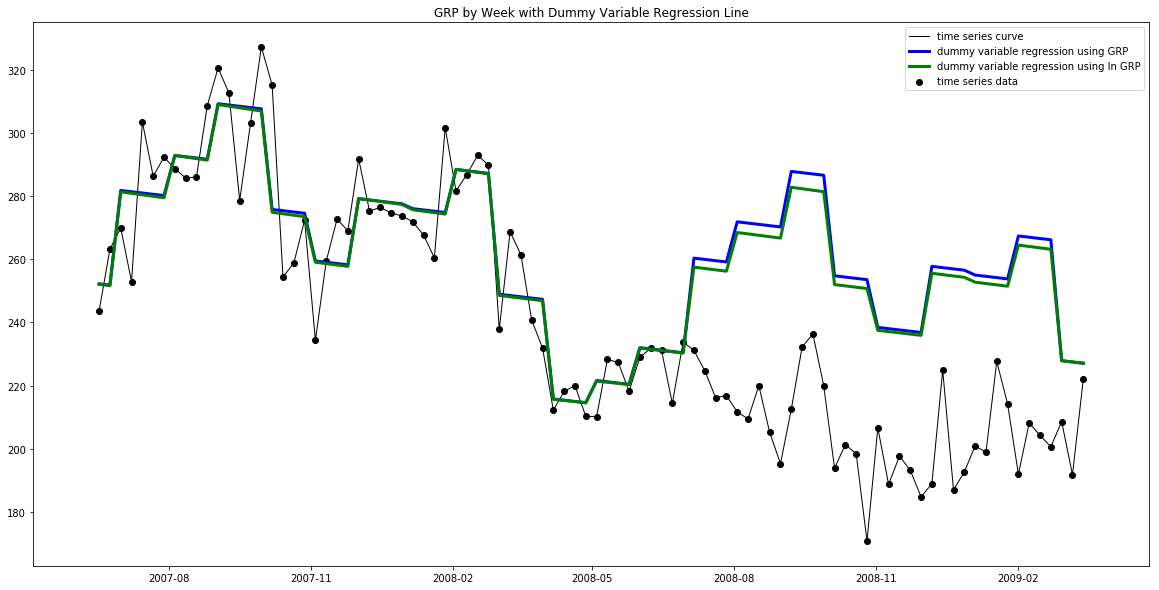

In [56]:
plt.figure(figsize=(20, 10))
plt.title('GRP by Week with Dummy Variable Regression Line')
plt.scatter(ts_df.index.values, ts_df['GRP'].values, color='black', label='time series data')
plt.plot(ts_df.index.values, ts_df['GRP'].values, color='black', linewidth=1, label='time series curve')
plt.plot(ts_df.index.values, np.concatenate([dummy_var_reg_train_pred, dummy_var_reg_test_pred]), color='blue',
         linewidth=3, label='dummy variable regression using GRP')
plt.plot(ts_df.index.values, np.concatenate([dummy_var_reg_trnsf_train_pred, dummy_var_reg_trnsf_test_pred]), color='green',
         linewidth=3, label='dummy variable regression using ln GRP')
plt.legend()
plt.show()

The dummy variable regression model generalises poorly to the test data. While it captures the seasonality, it looks like the linear model fails to sufficiently capture the trend even using the Box-Cox transformation.

In [57]:
residuals = train_ts_dummy_df['GRP'].values - dummy_var_reg_train_pred
dummy_var_reg_res = Pipeline(
    [
        ('poly', PolynomialFeatures(degree=4)),
        ('linear', LinearRegression(fit_intercept=False))])
dummy_var_reg_res.fit(train_ts_dummy_df['week'].values.reshape(-1, 1), residuals)
dummy_var_reg_res_pred = dummy_var_reg_res.predict(train_ts_dummy_df['week'].values.reshape(-1, 1))

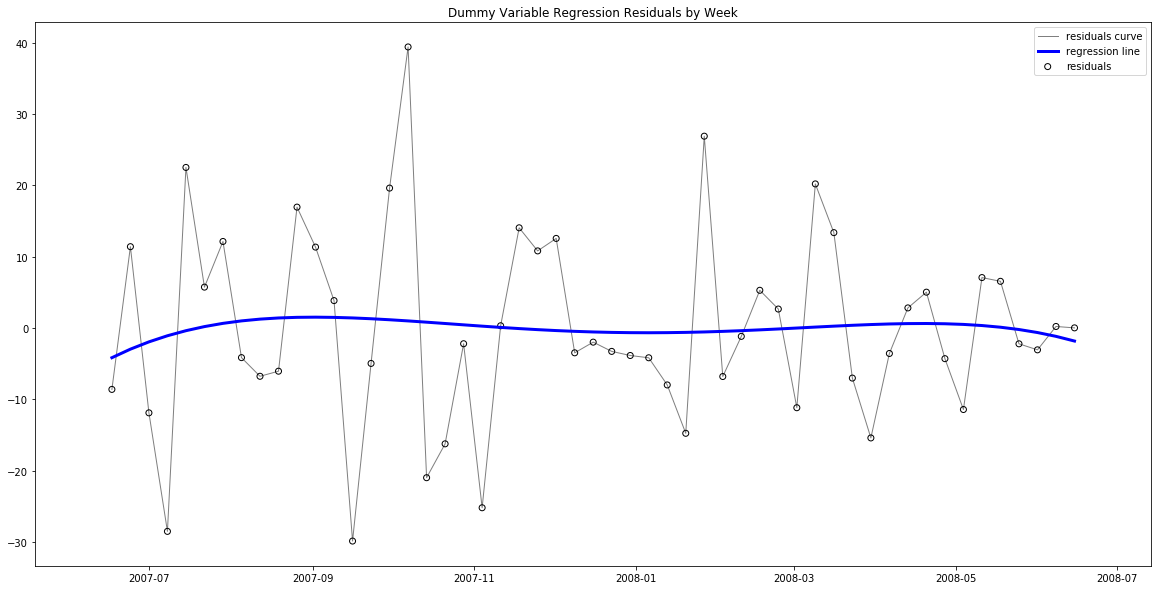

In [58]:
plt.figure(figsize=(20, 10))
plt.title('Dummy Variable Regression Residuals by Week')
plt.scatter(train_ts_df.index.values, residuals, color='black', marker='o', label='residuals', facecolors='none')
plt.plot(train_ts_df.index.values, residuals, color='black', linewidth=1, label='residuals curve', alpha=.5)
plt.plot(train_ts_df.index.values, dummy_var_reg_res_pred, color='blue', linewidth=3, label='regression line')
plt.legend()
plt.show()

The linear regression model using trend(time) and dummy variables for seasonality is a valid linear model although it generalises poorly. 

## Conclusion

In [59]:
results_df = pd.DataFrame(results_list, index=['Linear Regression', 'Polynomial Regression', 'Dummy Variable Regression', 'Dummy Variable Regression with Box_Cox'],
                          columns=['train mse', 'train rmse', 'train r2', 'test mse', 'test rmse'])
results_df

,train mse,train rmse,train r2,test mse,test rmse
Linear Regression,552.069285,23.496155,0.413926,277.590290,16.661041
Polynomial Regression,392.078675,19.800977,0.583771,5331.790540,73.019111
Dummy Variable Regression,178.852264,13.373566,0.810131,2819.982555,53.103508
Dummy Variable Regression with Box_Cox,179.350545,13.392182,0.809602,2551.448216,50.511862
